### todo
- write to temp file
- stationary and passive noise reduction

In [1]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
url = "https://auditoryneuroscience.com/sites/default/files/bushOffersPeace.ogg"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))
data = data

In [590]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [591]:
data = butter_bandpass_filter(data, 50, 16000, rate, order=2)

In [592]:
IPython.display.Audio(data=data, rate=rate)

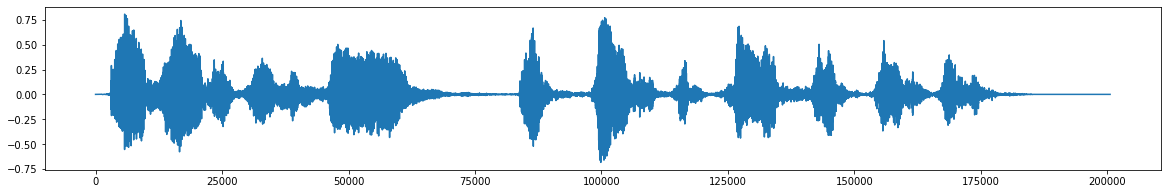

In [593]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

In [648]:
import librosa

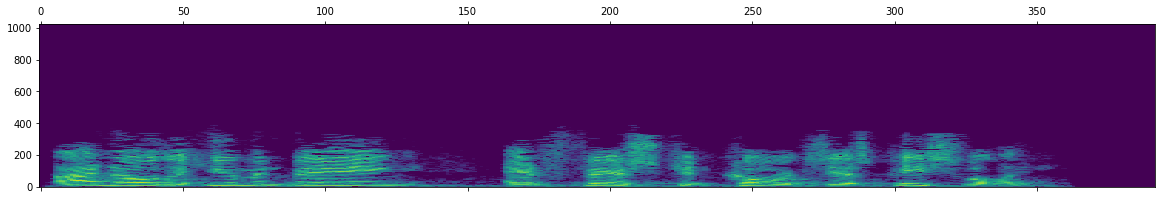

In [766]:
D = np.abs(librosa.stft(data))**2
D_db = librosa.power_to_db(D, ref=np.max)
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(D_db, origin='lower', aspect='auto')

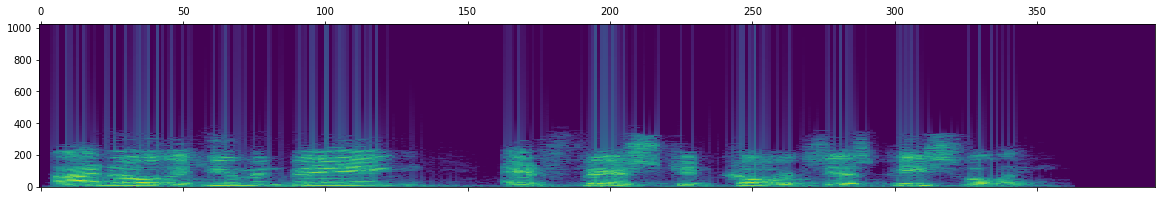

In [767]:
Dt = np.abs(torch.stft(torch.from_numpy(data), n_fft=2048, return_complex=True))**2
D_db = librosa.power_to_db(Dt, ref=np.max)
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(D_db, origin='lower', aspect='auto')

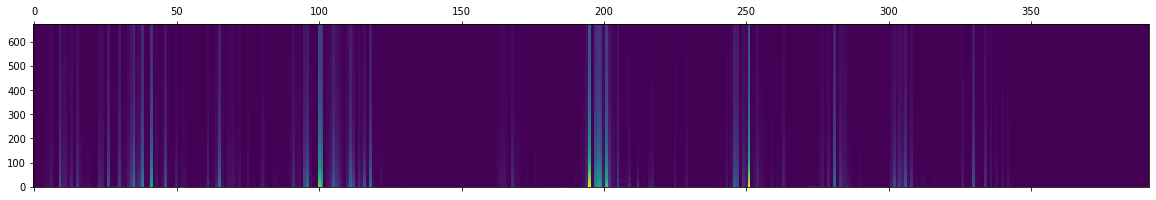

In [780]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow((np.abs(D[350:,:]-Dt.numpy()[350:,:])), origin='lower', aspect='auto')

### add noise

In [909]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*5
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

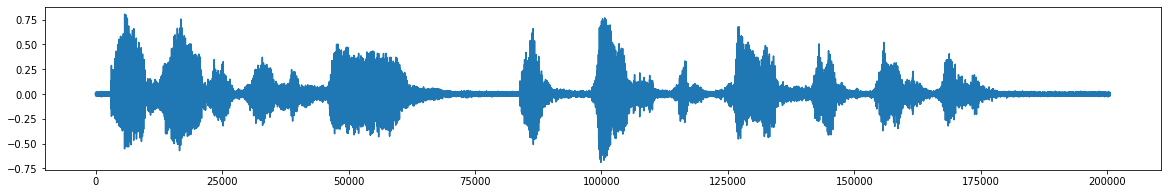

In [910]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [911]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

In [912]:
import torch

In [913]:
from time import perf_counter

In [914]:
from scipy.signal import filtfilt

In [915]:
chunk = audio_clip_band_limited

In [916]:
_time_constant = time_constant=2
_win_length_ms = win_length_ms=6
_hop_length_ms = hop_length_ms=3
_thresh_n_mult=0.5
_sigmoid_slope=20
filter_padding=3000
chunk_size=30000
cache_chunks=False
dtype=None
_n_fft = 264

In [917]:
sampling_frequency = rate
hop_length = hop_length_frames = int(
    sampling_frequency / 1000 * _hop_length_ms
)
win_length = win_length_frames = int(
    sampling_frequency / 1000 * _win_length_ms
)

In [918]:
_n_fft, win_length

(264, 264)

In [919]:
def sigmoid(x, shift, mult):
    """
    Using this sigmoid to discourage one network overpowering the other
    """
    return 1 / (1 + torch.exp(-(x + shift) * mult))

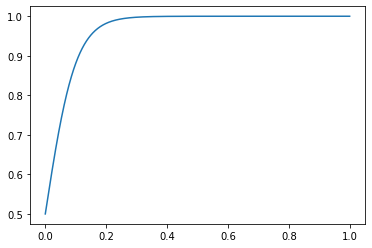

In [920]:
x = np.linspace(0,1,1000)
y  = 1 / (1 + np.exp(-(x + 0) * _sigmoid_slope))
plt.plot(x, y)

In [921]:
timeit = True

In [922]:
def get_time_smoothed_representation(
    spectral, samplerate, hop_length, time_constant=0.001
):
    t_frames = time_constant * samplerate / float(hop_length)
    # By default, this solves the equation for b:
    #   b**2  + (1 - b) / t_frames  - 2 = 0
    # which approximates the full-width half-max of the
    # squared frequency response of the IIR low-pass filt
    b = (np.sqrt(1 + 4 * t_frames ** 2) - 1) / (2 * t_frames ** 2)
    return filtfilt([b], [1, b - 1], spectral, axis=-1, padtype=None)


In [923]:
if timeit:
        print("torch")
        start = perf_counter()
sig_stft = torch.stft(
    torch.from_numpy(chunk), _n_fft, hop_length, win_length, return_complex=True
)
if timeit:
    print("stft time: ", perf_counter() - start)
    print(sig_stft.is_cuda)
    start = perf_counter()
# get abs of signal stft
abs_sig_stft = torch.abs(sig_stft)
# get the smoothed mean of the signal
sig_stft_smooth = torch.from_numpy(
    get_time_smoothed_representation(
        abs_sig_stft, sampling_frequency, hop_length, time_constant=_time_constant
    ).copy()
)
if timeit:
    print("smooth time: ", perf_counter() - start)
    start = perf_counter()
# get the number of X above the mean the signal is
sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
# mask based on sigmoid
sig_stft_mask = sigmoid(sig_mult_above_thresh, -_thresh_n_mult, _sigmoid_slope)
if timeit:
    print("gate time: ", perf_counter() - start)
    start = perf_counter()
# multiply signal with mask
sig_stft_denoised = sig_stft * sig_stft_mask
# invert/recover the signal
denoised_signal = torch.istft(
    sig_stft_denoised, _n_fft, hop_length, win_length
).numpy()
if timeit:
    print("invert time: ", perf_counter() - start)
    start = perf_counter()

torch
stft time:  0.0054177711717784405
False
smooth time:  0.006666852161288261
gate time:  0.002852309960871935
invert time:  0.006906603928655386


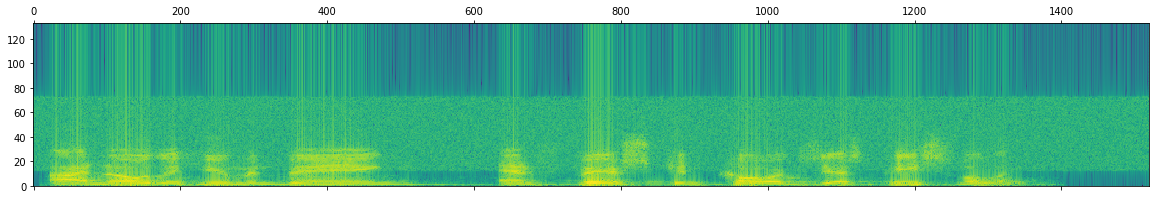

In [924]:
fig, ax = plt.subplots(figsize=(20,3))

ax.matshow(np.log(abs_sig_stft), origin='lower', aspect='auto')

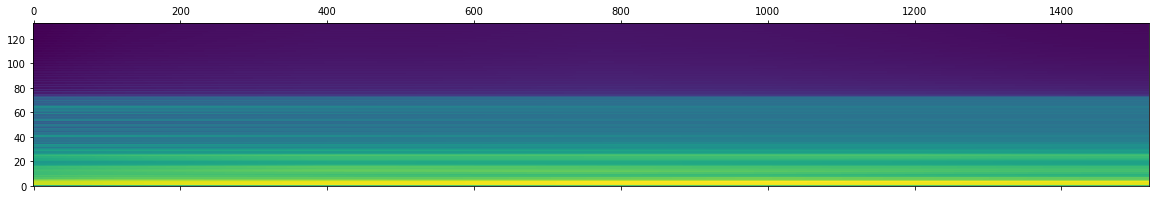

In [925]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(sig_stft_smooth), origin='lower', aspect='auto')

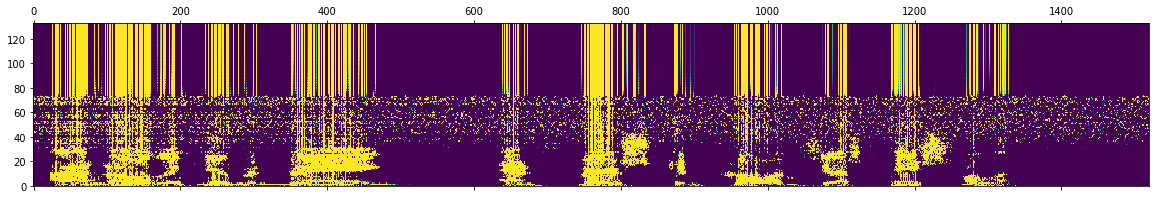

In [926]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(sig_stft_mask, origin='lower', aspect='auto')

In [927]:
np.min(sig_stft_mask.numpy()), np.max((sig_stft_mask.numpy()))

(9.360154740848692e-14, 1.0)

In [928]:
rate

44100

In [929]:
denoised_signal = butter_bandpass_filter(denoised_signal, 50, 16000, rate, order=2)

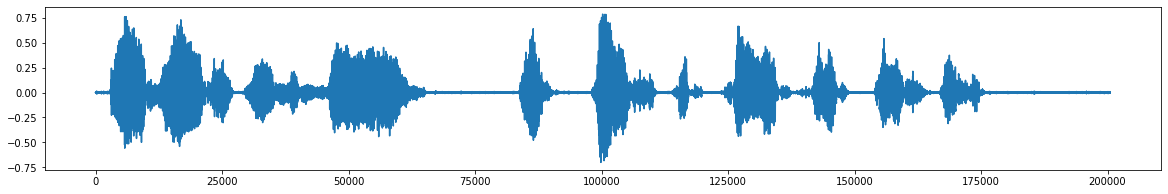

In [930]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(denoised_signal)

In [931]:
IPython.display.Audio(data=denoised_signal, rate=rate)

In [932]:
def _smoothing_filter(n_grad_freq, n_grad_time):
    """Generates a filter to smooth the mask for the spectrogram
        
    Arguments:
        n_grad_freq {[type]} -- [how many frequency channels to smooth over with the mask.]
        n_grad_time {[type]} -- [how many time channels to smooth over with the mask.]
    """

    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    return smoothing_filter

In [933]:
n_grad_freq=2
n_grad_time=4

In [934]:
smoothing_filter = _smoothing_filter(n_grad_freq, n_grad_time)

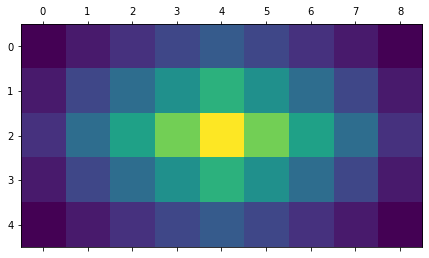

In [935]:
plt.matshow(smoothing_filter)

In [936]:
import scipy

In [937]:
# convolve the mask with a smoothing filter
sig_mask = scipy.signal.fftconvolve(sig_stft_mask, smoothing_filter, mode="same")

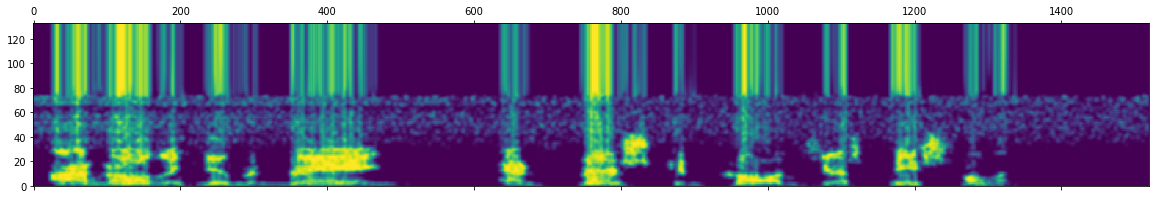

In [938]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(sig_mask, origin='lower', aspect='auto')

In [939]:
# multiply signal with mask
sig_stft_denoised = sig_stft * sig_mask

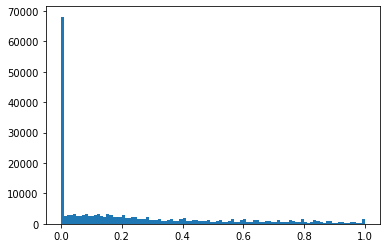

In [940]:
plt.hist(sig_mask.flatten(), bins = 100);

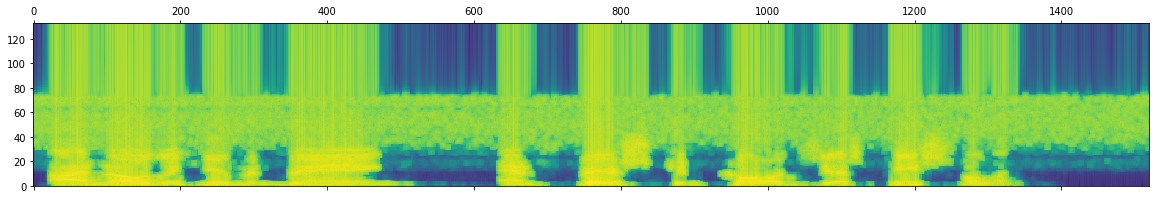

In [941]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(np.abs(sig_stft_denoised)), origin='lower', aspect='auto')

In [942]:
# invert/recover the signal
denoised_signal = torch.istft(
    sig_stft_denoised, _n_fft, hop_length, win_length
)

In [943]:
denoised_signal

tensor([-0.0006,  0.0002,  0.0007,  ...,  0.0003,  0.0004, -0.0001],
       dtype=torch.float64)

In [944]:
recovered_stft = np.abs(torch.stft(
    denoised_signal, _n_fft, hop_length, win_length, return_complex=True
))

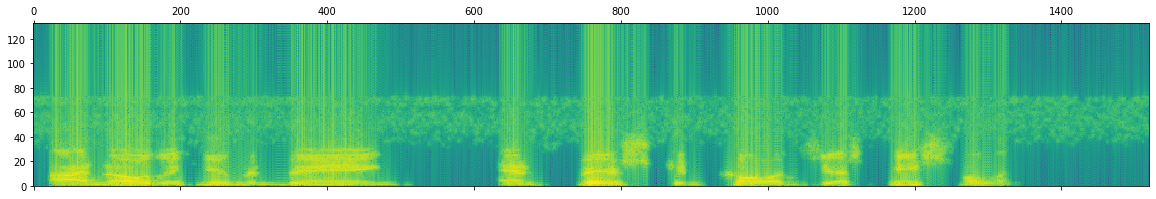

In [945]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(recovered_stft), origin='lower', aspect='auto')

In [946]:
denoised_signal = butter_bandpass_filter(denoised_signal, 50, 16000, rate, order=2)

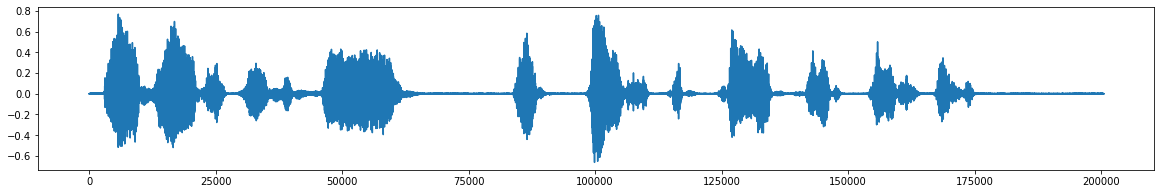

In [947]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(denoised_signal)

In [948]:
IPython.display.Audio(data=denoised_signal, rate=rate)

# without torch

In [1089]:
_time_constant = time_constant=2
_win_length_ms = win_length_ms=6
_hop_length_ms = hop_length_ms=3
_thresh_n_mult=2
_sigmoid_slope=100
filter_padding=3000
chunk_size=30000
cache_chunks=False
dtype=None
_n_fft = 264

In [1090]:
def sigmoid(x, shift, mult):
    """
    Using this sigmoid to discourage one network overpowering the other
    """
    return 1 / (1 + np.exp(-(x + shift) * mult))

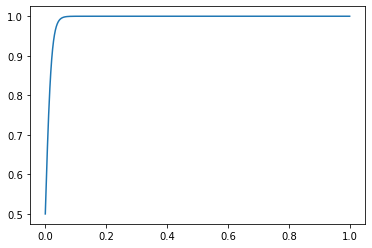

In [1091]:
x = np.linspace(0,1,1000)
y  = 1 / (1 + np.exp(-(x + 0) * _sigmoid_slope))
plt.plot(x, y)

In [1092]:
timeit = True

In [1093]:
def get_time_smoothed_representation(
    spectral, samplerate, hop_length, time_constant=0.001
):
    t_frames = time_constant * samplerate / float(hop_length)
    # By default, this solves the equation for b:
    #   b**2  + (1 - b) / t_frames  - 2 = 0
    # which approximates the full-width half-max of the
    # squared frequency response of the IIR low-pass filt
    b = (np.sqrt(1 + 4 * t_frames ** 2) - 1) / (2 * t_frames ** 2)
    return filtfilt([b], [1, b - 1], spectral, axis=-1, padtype=None)


In [1094]:
if timeit:
        print("torch")
        start = perf_counter()
sig_stft = librosa.stft(
    (chunk), n_fft=_n_fft, hop_length=hop_length, win_length=win_length,
)
if timeit:
    print("stft time: ", perf_counter() - start)
    start = perf_counter()
# get abs of signal stft
abs_sig_stft = np.abs(sig_stft)
# get the smoothed mean of the signal
sig_stft_smooth = get_time_smoothed_representation(
        abs_sig_stft, sampling_frequency, hop_length, time_constant=_time_constant
    
)
if timeit:
    print("smooth time: ", perf_counter() - start)
    start = perf_counter()
# get the number of X above the mean the signal is
sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
# mask based on sigmoid
sig_stft_mask = sigmoid(sig_mult_above_thresh, -_thresh_n_mult, _sigmoid_slope)
if timeit:
    print("gate time: ", perf_counter() - start)
    start = perf_counter()
# multiply signal with mask
sig_stft_denoised = sig_stft * sig_stft_mask
# invert/recover the signal
denoised_signal = librosa.istft(
    sig_stft_denoised, hop_length=hop_length, win_length=win_length
)
if timeit:
    print("invert time: ", perf_counter() - start)
    start = perf_counter()

torch
stft time:  0.010530220810323954
smooth time:  0.00834279926493764
gate time:  0.007537619676440954
invert time:  0.014220837969332933


In [1095]:
denoised_signal

array([-1.31512294e-48,  7.89440405e-13, -6.13834910e-12, ...,
        2.10669576e-03,  5.43907742e-04, -2.21673604e-03])

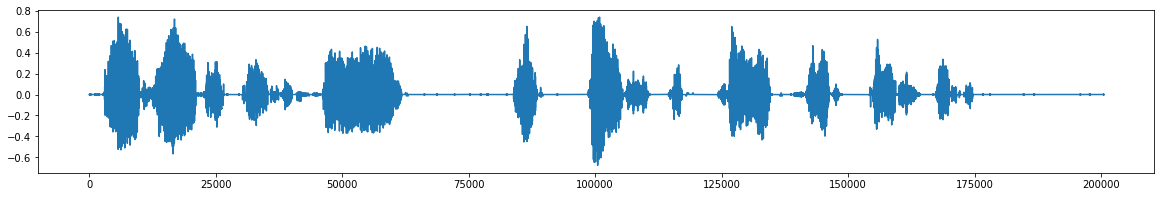

In [1096]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(denoised_signal)

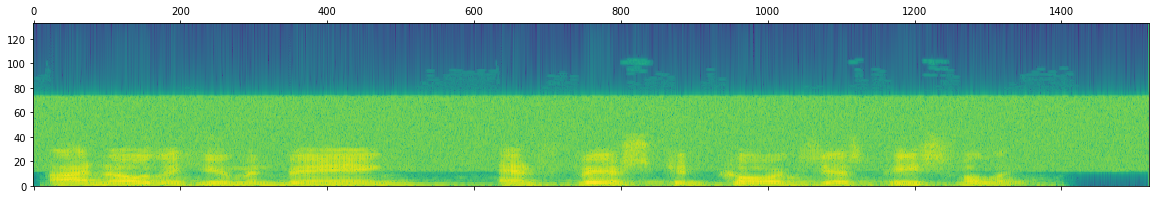

In [1097]:
fig, ax = plt.subplots(figsize=(20,3))

ax.matshow(np.log(abs_sig_stft), origin='lower', aspect='auto')

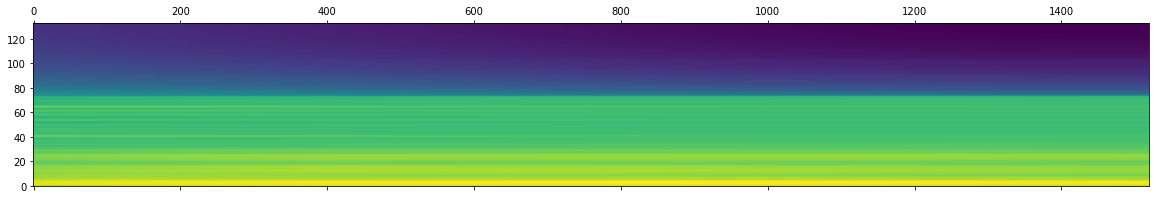

In [1098]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(sig_stft_smooth), origin='lower', aspect='auto')

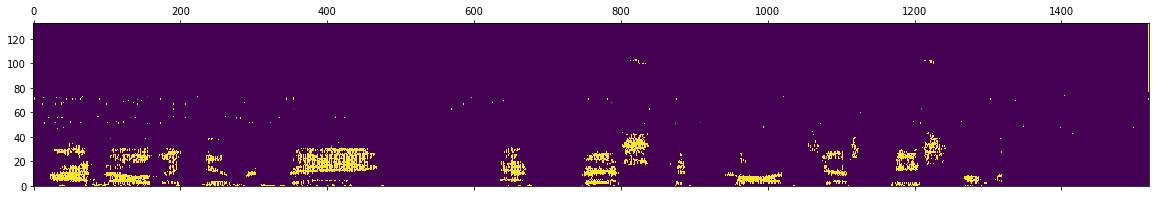

In [1099]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(sig_stft_mask, origin='lower', aspect='auto')

In [1100]:
denoised_signal = butter_bandpass_filter(denoised_signal, 50, 16000, rate, order=2)

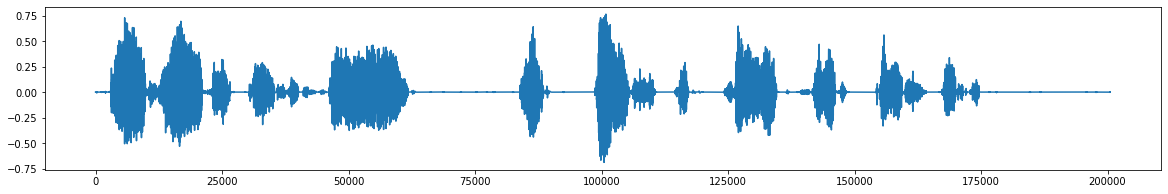

In [1101]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(denoised_signal)

In [1102]:
IPython.display.Audio(data=denoised_signal, rate=rate)

In [1103]:
def _smoothing_filter(n_grad_freq, n_grad_time):
    """Generates a filter to smooth the mask for the spectrogram
        
    Arguments:
        n_grad_freq {[type]} -- [how many frequency channels to smooth over with the mask.]
        n_grad_time {[type]} -- [how many time channels to smooth over with the mask.]
    """

    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    return smoothing_filter

In [1104]:
n_grad_freq=4
n_grad_time=8

In [1105]:
smoothing_filter = _smoothing_filter(n_grad_freq, n_grad_time)

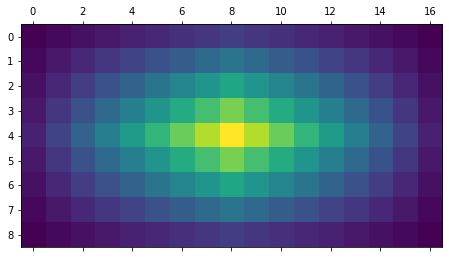

In [1106]:
plt.matshow(smoothing_filter)

In [1107]:
import scipy

In [1108]:
# convolve the mask with a smoothing filter
sig_mask = scipy.signal.fftconvolve(sig_stft_mask, smoothing_filter, mode="same")

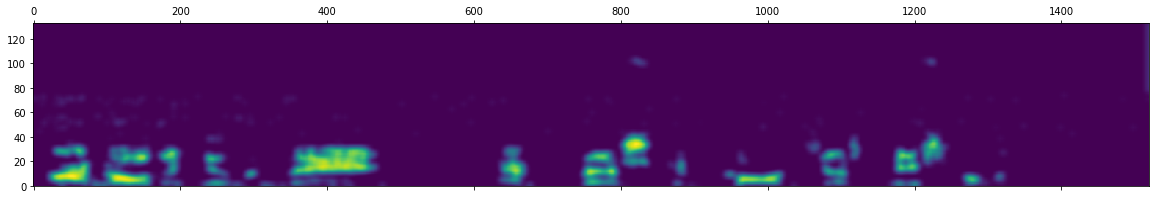

In [1109]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(sig_mask, origin='lower', aspect='auto')

In [1110]:
# multiply signal with mask
sig_stft_denoised = sig_stft * sig_mask

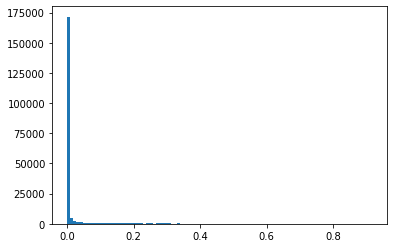

In [1111]:
plt.hist(sig_mask.flatten(), bins = 100);

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


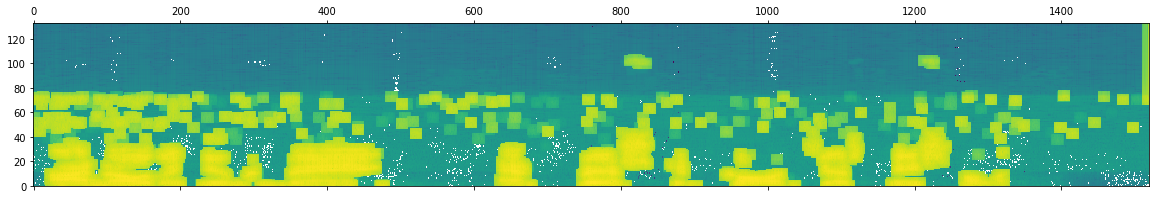

In [1112]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(np.abs(sig_stft_denoised)), origin='lower', aspect='auto')

In [1113]:
# invert/recover the signal
denoised_signal = librosa.istft(
    sig_stft_denoised, hop_length=hop_length, win_length=win_length
)

In [1114]:
denoised_signal

array([-2.14748740e-05,  1.27775593e-06,  2.16230454e-05, ...,
        1.06391933e-04,  3.00114846e-05, -1.10774263e-04])

In [1115]:
recovered_stft = np.abs(librosa.stft(
    denoised_signal, _n_fft, hop_length, win_length,
))

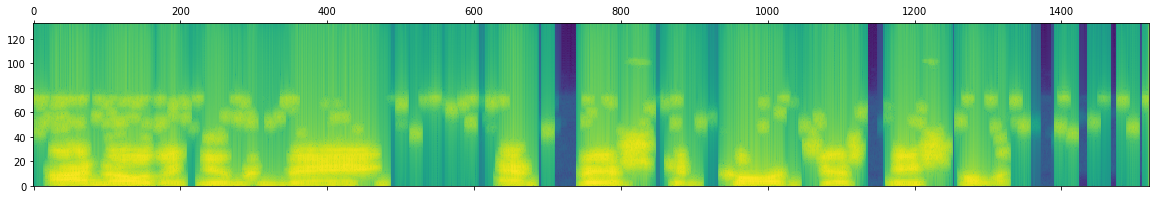

In [1116]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(recovered_stft), origin='lower', aspect='auto')

In [1117]:
denoised_signal = butter_bandpass_filter(denoised_signal, 50, 16000, rate, order=2)

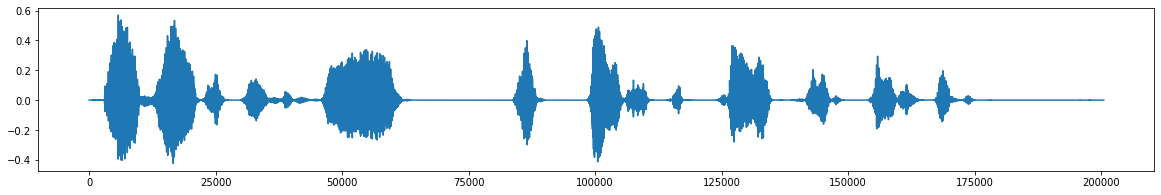

In [1118]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(denoised_signal)

In [1119]:
IPython.display.Audio(data=denoised_signal, rate=rate)

In [1140]:
_thresh_n_mult=1


In [1141]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
response = urllib.request.urlopen(url)
noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

In [1142]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = data + noise_clip

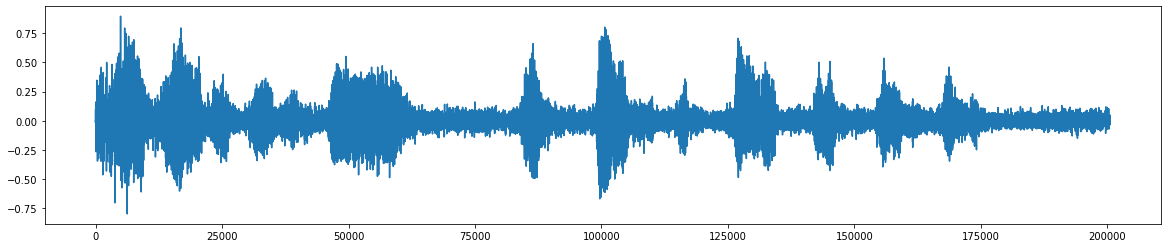

In [1143]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)

IPython.display.Audio(data=audio_clip_cafe, rate=noise_rate)

In [1144]:
chunk = audio_clip_cafe

In [1252]:
_time_constant = time_constant=0.5
_win_length_ms = win_length_ms=6
_hop_length_ms = hop_length_ms=3
_thresh_n_mult=1
_sigmoid_slope=20
filter_padding=3000
chunk_size=30000
cache_chunks=False
dtype=None
_n_fft = 264

In [1253]:
if timeit:
        print("torch")
        start = perf_counter()
sig_stft = librosa.stft(
    (chunk), n_fft=_n_fft, hop_length=hop_length, win_length=win_length,
)
if timeit:
    print("stft time: ", perf_counter() - start)
    start = perf_counter()
# get abs of signal stft
abs_sig_stft = np.abs(sig_stft)
# get the smoothed mean of the signal
sig_stft_smooth = get_time_smoothed_representation(
        abs_sig_stft, sampling_frequency, hop_length, time_constant=_time_constant
    
)
if timeit:
    print("smooth time: ", perf_counter() - start)
    start = perf_counter()
# get the number of X above the mean the signal is
sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
# mask based on sigmoid
sig_stft_mask = sigmoid(sig_mult_above_thresh, -_thresh_n_mult, _sigmoid_slope)
if timeit:
    print("gate time: ", perf_counter() - start)
    start = perf_counter()
# multiply signal with mask
sig_stft_denoised = sig_stft * sig_stft_mask
# invert/recover the signal
denoised_signal = librosa.istft(
    sig_stft_denoised, hop_length=hop_length, win_length=win_length
)
if timeit:
    print("invert time: ", perf_counter() - start)
    start = perf_counter()

torch
stft time:  0.009761226829141378
smooth time:  0.007823009043931961
gate time:  0.007904371712356806
invert time:  0.015598227269947529


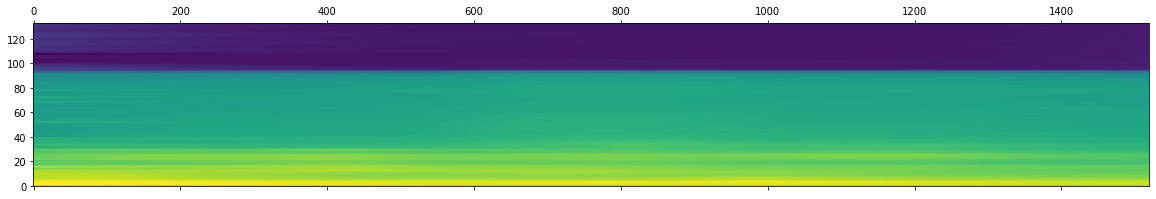

In [1254]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(sig_stft_smooth), origin='lower', aspect='auto')

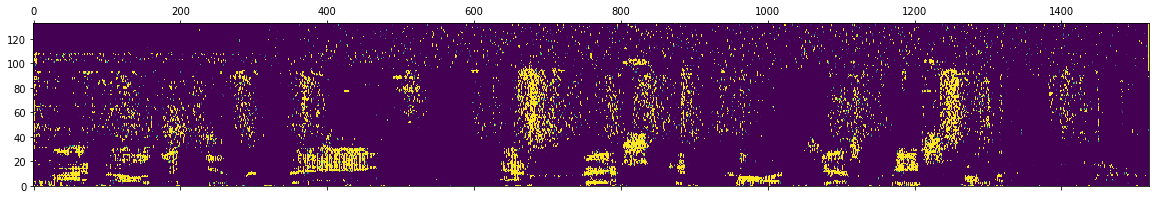

In [1255]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(sig_stft_mask, origin='lower', aspect='auto')

In [1256]:
# convolve the mask with a smoothing filter
sig_mask = scipy.signal.fftconvolve(sig_stft_mask, smoothing_filter, mode="same")

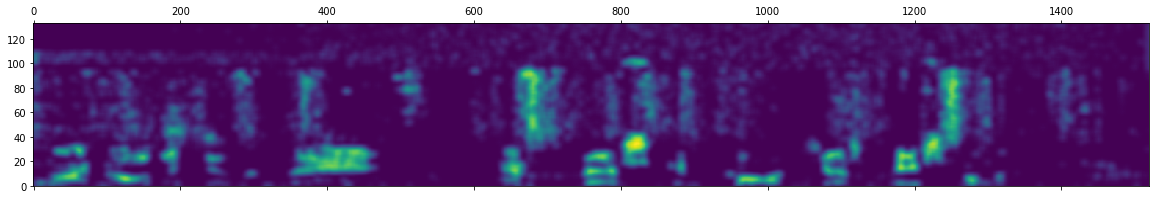

In [1257]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(sig_mask, origin='lower', aspect='auto')

In [1258]:
# multiply signal with mask
sig_stft_denoised = sig_stft * sig_mask

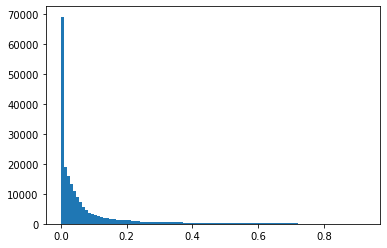

In [1259]:
plt.hist(sig_mask.flatten(), bins = 100);

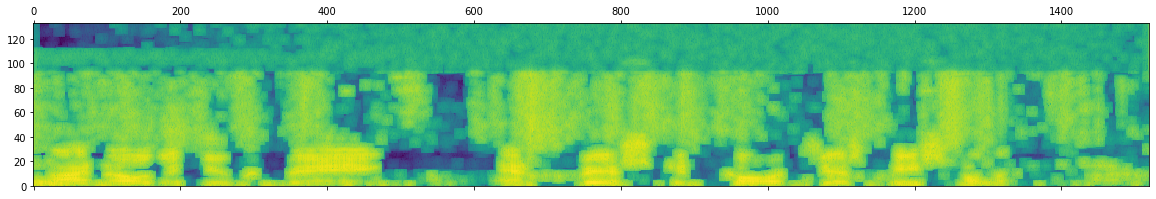

In [1260]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(np.log(np.abs(sig_stft_denoised)), origin='lower', aspect='auto')

In [1261]:
# invert/recover the signal
denoised_signal = librosa.istft(
    sig_stft_denoised, hop_length=hop_length, win_length=win_length
)

In [1262]:
denoised_signal

array([0.00403539, 0.0038227 , 0.00315868, ..., 0.00014504, 0.00026435,
       0.00028755])

In [1263]:
recovered_stft = np.abs(librosa.stft(
    denoised_signal, _n_fft, hop_length, win_length,
))

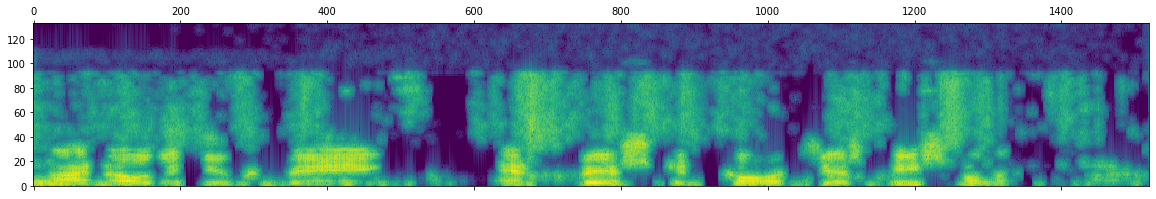

In [1269]:
fig, ax = plt.subplots(figsize=(20,3))
ax.matshow(librosa.power_to_db(recovered_stft, ref=np.max), origin='lower', aspect='auto')

In [1265]:
denoised_signal = butter_bandpass_filter(denoised_signal, 50, 16000, rate, order=2)

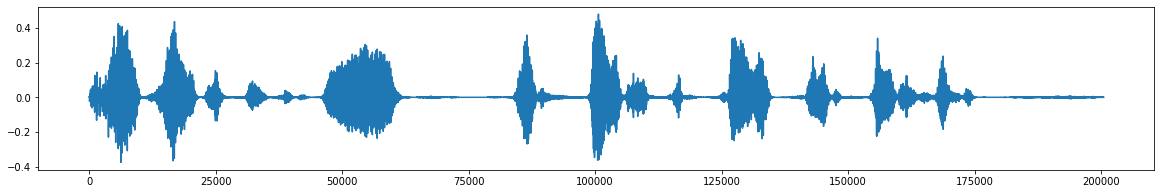

In [1266]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(denoised_signal)

In [1267]:
IPython.display.Audio(data=denoised_signal, rate=rate)

In [1271]:
len(denoised_signal)


200508

In [1272]:
len(chunk)

200542